In [1]:
!pip install torchinfo
!nvidia-smi

Sat Jul  6 10:18:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# import
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision import models
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone
from tqdm import tqdm

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)  # 출력결과: cuda

if DEVICE.type == "cuda":
    print("Count of using GPUs:", torch.cuda.device_count())
    print("Current cuda device:", torch.cuda.current_device())
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")

    print("Memory Cached:", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Device: cpu


In [3]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.01
BATCH_SIZE = 128
EPOCHS = 25
IMG_SIZE = 224
NUM_CLASSES = 10

# 규제화 파라미터 설정
DROPOUT = 0.5

In [4]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [5]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [6]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [7]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [8]:
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Validation {epoch + 1}/{epochs}", leave=False)
        with torch.no_grad():
            for inputs, labels in valid_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
        
        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch + 1}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [13]:
class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=False):
        super(BottleneckResidualBlock, self).__init__()
        o1, o2, o3 = out_channels
        self.conv1 = nn.Conv2d(
            in_channels, o1, kernel_size=1, stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(o1)
        self.conv2 = nn.Conv2d(o1, o2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(o2)
        self.conv3 = nn.Conv2d(o2, o3, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(o3)

        if downsample:
            self.downsample = nn.Conv2d(in_channels, o3, kernel_size=1, stride=stride, bias=False)
            self.bn_downsample = nn.BatchNorm2d(o3)
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.downsample:
            identity = self.bn_downsample(self.downsample(identity))
        x = F.relu(x + identity)
        return x


class ResNet50Conv2_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv2_x, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_a = BottleneckResidualBlock(
            64, [64, 64, 256], stride=1, downsample=True
        )
        self.conv2_b = BottleneckResidualBlock(256, [64, 64, 256], stride=1)
        self.conv2_c = BottleneckResidualBlock(256, [64, 64, 256], stride=1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv2_a(x)
        x = self.conv2_b(x)
        x = self.conv2_c(x)
        return x


class ResNet50Conv3_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv3_x, self).__init__()
        self.conv3_a = BottleneckResidualBlock(
            256, [128, 128, 512], stride=2, downsample=True
        )
        self.conv3_b = BottleneckResidualBlock(512, [128, 128, 512], stride=1)
        self.conv3_c = BottleneckResidualBlock(512, [128, 128, 512], stride=1)
        self.conv3_d = BottleneckResidualBlock(512, [128, 128, 512], stride=1)

    def forward(self, x):
        x = self.conv3_a(x)
        x = self.conv3_b(x)
        x = self.conv3_c(x)
        x = self.conv3_d(x)
        return x


class ResNet50Conv4_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv4_x, self).__init__()
        self.conv4_a = BottleneckResidualBlock(
            512, [256, 256, 1024], stride=2, downsample=True
        )
        self.conv4_b = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_c = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_d = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_e = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_f = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)

    def forward(self, x):
        x = self.conv4_a(x)
        x = self.conv4_b(x)
        x = self.conv4_c(x)
        x = self.conv4_d(x)
        x = self.conv4_e(x)
        x = self.conv4_f(x)
        return x


class ResNet50Conv5_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv5_x, self).__init__()
        self.conv5_a = BottleneckResidualBlock(
            1024, [512, 512, 2048], stride=2, downsample=True
        )
        self.conv5_b = BottleneckResidualBlock(2048, [512, 512, 2048], stride=1)
        self.conv5_c = BottleneckResidualBlock(2048, [512, 512, 2048], stride=1)

    def forward(self, x):
        x = self.conv5_a(x)
        x = self.conv5_b(x)
        x = self.conv5_c(x)
        return x


# ResNet50 모델 정의
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2_x = ResNet50Conv2_x()
        self.conv3_x = ResNet50Conv3_x()
        self.conv4_x = ResNet50Conv4_x()
        self.conv5_x = ResNet50Conv5_x()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


torchinfo.summary(
    ResNet50(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

# torchinfo.summary(
#     models.resnet50(pretrained=False),
#     input_size=(1, 3, IMG_SIZE, IMG_SIZE),
# )
# 1000개 클래스 분류에 대해서 학습 파라미터 수가 동일함을 확인

Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
ResNet50 (ResNet50)                                [1, 3, 224, 224]          [1, 10]                   --                        --
├─Conv2d (conv1): 1-1                              [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]
├─BatchNorm2d (bn1): 1-2                           [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --
├─ResNet50Conv2_x (conv2_x): 1-3                   [1, 64, 112, 112]         [1, 256, 56, 56]          --                        --
│    └─MaxPool2d (pool): 2-1                       [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3
│    └─BottleneckResidualBlock (conv2_a): 2-2      [1, 64, 56, 56]           [1, 256, 56, 56]          --                        --
│    │    └─Conv2d (conv1): 3-1                    [1, 64, 56, 

100%|██████████| 170498071/170498071 [00:01<00:00, 104580563.26it/s]


Extracting cifar10_data/cifar-10-python.tar.gz to cifar10_data


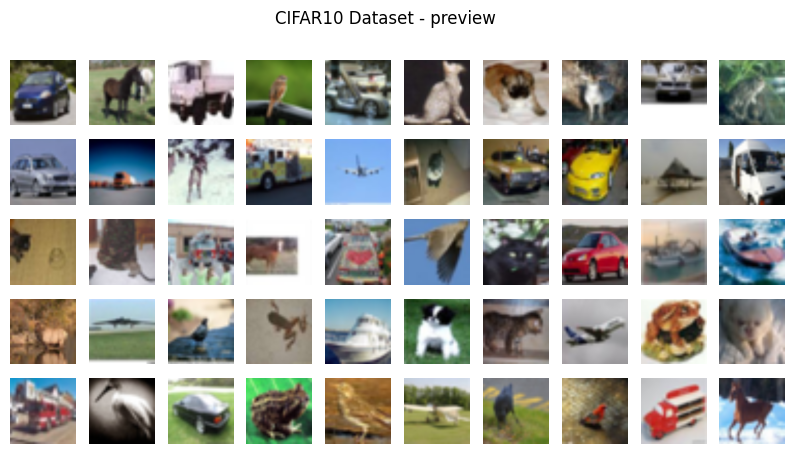

Train dataset size: 50000
Validation dataset size: 10000


In [10]:
# transforms 정의하기
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE),),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
train_dataset = datasets.CIFAR10(
    root="cifar10_data", train=True, transform=transform, download=True
)

valid_dataset = datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 불러온 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(10, 5))  # 창 크기 조정
for i, (image, label) in enumerate(train_loader):
    if i == ROW_IMG * N_ROWS:
        break
    ax = plt.subplot(N_ROWS, ROW_IMG, i + 1)
    ax.axis("off")
    # 이미지 표시하기
    plt.imshow(transforms.ToPILImage()(image[0]))

fig.suptitle("CIFAR10 Dataset - preview")
plt.show()


# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")

19:18:30 --- Start Training Loop ---


19:22:46 ---  Epoch: 1	Train loss: 1.4164	Valid loss: 1.2018	Train accuracy: 58.28	Valid accuracy: 56.68


19:27:03 ---  Epoch: 2	Train loss: 0.8885	Valid loss: 0.8124	Train accuracy: 73.51	Valid accuracy: 72.01


19:31:19 ---  Epoch: 3	Train loss: 0.6539	Valid loss: 0.6591	Train accuracy: 80.53	Valid accuracy: 77.54


19:35:34 ---  Epoch: 4	Train loss: 0.5264	Valid loss: 0.5326	Train accuracy: 84.96	Valid accuracy: 81.71


19:39:51 ---  Epoch: 5	Train loss: 0.4469	Valid loss: 0.5702	Train accuracy: 84.94	Valid accuracy: 81.12


19:44:06 ---  Epoch: 6	Train loss: 0.3765	Valid loss: 0.4644	Train accuracy: 89.01	Valid accuracy: 84.51


19:48:22 ---  Epoch: 7	Train loss: 0.3269	Valid loss: 0.4865	Train accuracy: 89.05	Valid accuracy: 83.63


19:52:38 ---  Epoch: 8	Train loss: 0.2909	Valid loss: 0.4322	Train accuracy: 91.27	Valid accuracy: 85.34


19:56:54 ---  Epoch: 9	Train loss: 0.2457	Valid loss: 0.4584	Train accuracy: 91.97	Valid accuracy: 84.96


20:01:10 ---  Epoch: 10	Train loss: 0.2131	Valid loss: 0.4769	Train accuracy: 91.76	Valid accuracy: 84.50


20:05:26 ---  Epoch: 11	Train loss: 0.1882	Valid loss: 0.4576	Train accuracy: 93.09	Valid accuracy: 86.13


20:09:42 ---  Epoch: 12	Train loss: 0.1690	Valid loss: 0.4631	Train accuracy: 94.16	Valid accuracy: 86.22


20:13:58 ---  Epoch: 13	Train loss: 0.1440	Valid loss: 0.4604	Train accuracy: 94.67	Valid accuracy: 86.89


20:18:14 ---  Epoch: 14	Train loss: 0.1355	Valid loss: 0.4276	Train accuracy: 95.91	Valid accuracy: 87.18


20:22:29 ---  Epoch: 15	Train loss: 0.1171	Valid loss: 0.3895	Train accuracy: 97.03	Valid accuracy: 88.37


20:26:45 ---  Epoch: 16	Train loss: 0.1059	Valid loss: 0.5021	Train accuracy: 94.32	Valid accuracy: 85.22


20:31:00 ---  Epoch: 17	Train loss: 0.0847	Valid loss: 0.4878	Train accuracy: 96.19	Valid accuracy: 87.05


20:35:16 ---  Epoch: 18	Train loss: 0.0753	Valid loss: 0.4641	Train accuracy: 96.96	Valid accuracy: 87.49


20:39:31 ---  Epoch: 19	Train loss: 0.0662	Valid loss: 0.4038	Train accuracy: 98.36	Valid accuracy: 88.72


20:43:47 ---  Epoch: 20	Train loss: 0.0632	Valid loss: 0.4476	Train accuracy: 97.73	Valid accuracy: 88.07


20:48:03 ---  Epoch: 21	Train loss: 0.0542	Valid loss: 0.4781	Train accuracy: 97.29	Valid accuracy: 87.46


20:52:18 ---  Epoch: 22	Train loss: 0.0570	Valid loss: 0.5424	Train accuracy: 96.52	Valid accuracy: 86.99


20:56:33 ---  Epoch: 23	Train loss: 0.0494	Valid loss: 0.4902	Train accuracy: 97.58	Valid accuracy: 87.97


21:00:49 ---  Epoch: 24	Train loss: 0.0389	Valid loss: 0.4291	Train accuracy: 98.89	Valid accuracy: 89.05


21:05:05 ---  Epoch: 25	Train loss: 0.0382	Valid loss: 0.4408	Train accuracy: 98.88	Valid accuracy: 89.16


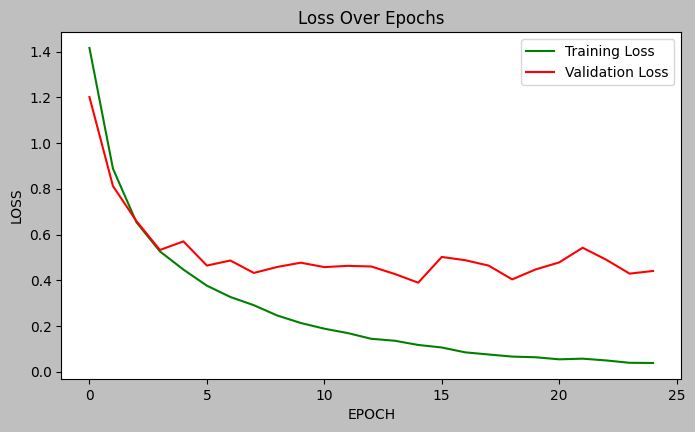

In [11]:
torch.manual_seed(RANDOM_SEED)

_model = ResNet50().cuda()
model = nn.DataParallel(_model).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.96)

criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, scheduler, train_loader, valid_loader, EPOCHS, DEVICE
)